# PETITE BSM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. It can also simulate dark sector production from an existing Standard Model shower. Currently, the only model implemented into PETITE for beyond-SM physics is that of a new boson with pure vector couplings to electrons. 

The tutorial notebook "tutorial.ipynb" provides an introduction to how PETITE uses importance sampling and the following electromagnetic processes to generate SM showers:

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_xsec.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_maps.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/dark_xsec.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/dark_weights.pkl

The following two files are included in PETITE by default, but if missing (or if new files are generated by the user), they are produced at the first instantiation of a `DarkShower`.

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/dark_weights.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/dark_drate.pkl

You can check versions with the code below and adjust if necessary

In this tutorial you will learn how to
1. Initialize a `DarkShower` object within PETITE and use it to sample individual dark processes
2. Use the `generate_shower` method  to generate SM electromagnetic showers generated by an initial high-energy photon
3. Repurpose those SM showers to predict downstream rates of a BSM particle through different new-physics processes via the `generate_dark_shower` method of `DarkShower`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

Python version:  3.11.8
Numpy version:  1.26.4
PETITE home directory: /Users/mhostert/Repos/PETITE/


### Load in dependencies and set font styles

In [3]:
from PETITE.dark_shower import *
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_shower(shower):
    photons = [p for p in shower if p.get_pid() == 22]
    electrons = [p for p in shower if p.get_pid() == 11]
    positrons = [p for p in shower if p.get_pid() == -11]
    print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))

    # Let's look at the energy and angle spectra of all particles.
    # Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
    
    E_min = np.min(np.concatenate([[p.get_p0()[0] for p in photons], [p.get_p0()[0] for p in electrons], [p.get_p0()[0] for p in positrons]]))
    E_max = np.max(np.concatenate([[p.get_p0()[0] for p in photons], [p.get_p0()[0] for p in electrons], [p.get_p0()[0] for p in positrons]]))
    
    angle_min = np.min(np.concatenate([[p.get_angle_to_z_0() for p in photons], [p.get_angle_to_z_0() for p in electrons], [p.get_angle_to_z_0() for p in positrons]]))
    angle_max = np.max(np.concatenate([[p.get_angle_to_z_0() for p in photons], [p.get_angle_to_z_0() for p in electrons], [p.get_angle_to_z_0() for p in positrons]]))
    
    
    bins_energy = np.linspace(E_min, E_max, 20) # MeV
    bins_angle = np.linspace(angle_min, angle_max, 20) # radians
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons', ls=(1, (3,0)))
    plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons', ls=(1, (3,1)))
    plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons', ls=(1, (3,3)))
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.subplot(122)
    plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons', ls=(1, (3,0)))
    plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons', ls=(1, (3,1)))
    plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons', ls=(1, (3,3)))
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Angle to z-axis at production (rad)')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/mhostert/Repos/PETITE/src/PETITE/xsec_integrands.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
ld: warning: duplicate -rpath '/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib' ignored
ld: warning: duplicate -rpath '/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib' ignored


In [56]:
E0 = 1. # energy of incident particle in GeV
# Define incident electron
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)

# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID': 11, 'ID':0, 'generation_number': 0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)


In [57]:
def get_shower_Graphite(integrator_path, load_xsec_interp):
    sgraphite = Shower(dict_dir=PETITE_home_dir+integrator_path, target_material="graphite", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=load_xsec_interp)
    return sgraphite, sgraphite.generate_shower(p0, VB=False)
def get_shower_Lead(integrator_path, load_xsec_interp):
    sLead = Shower(dict_dir=PETITE_home_dir+integrator_path, target_material="lead", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=load_xsec_interp)
    return sLead, sLead.generate_shower(p0, VB=False)


In [103]:
test_Lead, test_shower = get_shower_Graphite(integrator_path="coarsegrid_test/", load_xsec_interp=True)

In [104]:
## Comparing against creating the xsec and inv mfp interpolators from scratch
original_Lead, original_shower = get_shower_Graphite(integrator_path="coarsegrid_test/", load_xsec_interp=False)

In [105]:
%%prun

# Let's see what the bottlenecks are now:

# Before, they were 1) quad, 2) interp1d, 3) __call__ for brem, 4) __call__ for pair production.

tLead, test_shower = get_shower_Graphite(integrator_path="coarsegrid_test/", load_xsec_interp=True)

         381034 function calls (380993 primitive calls) in 0.937 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       43    0.350    0.008    0.515    0.012 shower.py:635(draw_sample)
        8    0.341    0.043    0.342    0.043 {built-in method _pickle.load}
    76276    0.070    0.000    0.070    0.000 all_processes.py:175(__call__)
   101847    0.044    0.000    0.044    0.000 {built-in method numpy.array}
    99488    0.030    0.000    0.030    0.000 {method 'random' of 'numpy.random.mtrand.RandomState' objects}
    23192    0.020    0.000    0.020    0.000 all_processes.py:558(__call__)
        1    0.010    0.010    0.352    0.352 shower.py:276(set_samples)
       51    0.008    0.000    0.526    0.010 shower.py:718(sample_scattering)
      446    0.005    0.000    0.022    0.000 moliere.py:404(get_scattered_momentum_fast)
      446    0.005    0.000    0.006    0.000 moliere.py:338(get_rotation_matrix)
       52  

In [106]:
from concurrent.futures import ThreadPoolExecutor

# Straight outta GPT
def parallel_shower(integrator_path, n_iterations, load_xsec_interp):
    def get_shower_wrapper():
        return get_shower_Graphite(integrator_path=integrator_path, load_xsec_interp=load_xsec_interp)[1]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda _: get_shower_wrapper(), range(n_iterations)))
    return np.concatenate(results)

In [ ]:
# Original map -- no xsec interpolators in this case
original_shower = parallel_shower(integrator_path="data/", n_iterations=10, load_xsec_interp=False)

In [107]:
# Test map -- uses xsec interpolators
test_shower = parallel_shower(integrator_path="coarsegrid_test/", n_iterations=20, load_xsec_interp=True)

Number of (photons, electrons, positrons):  205 755 196


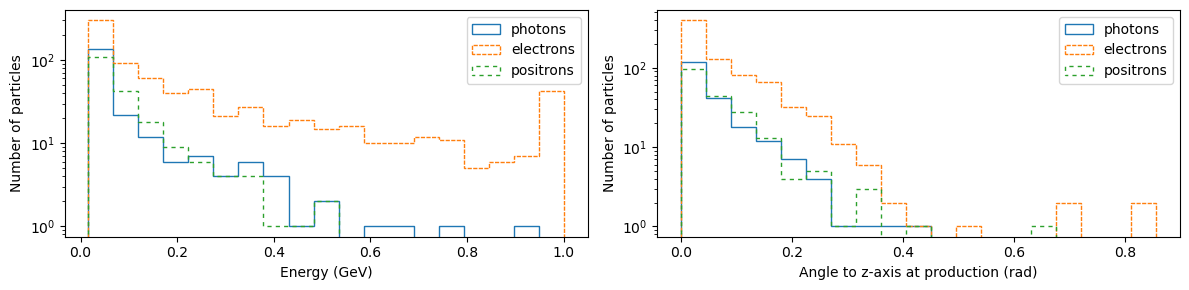

Number of (photons, electrons, positrons):  101 356 125


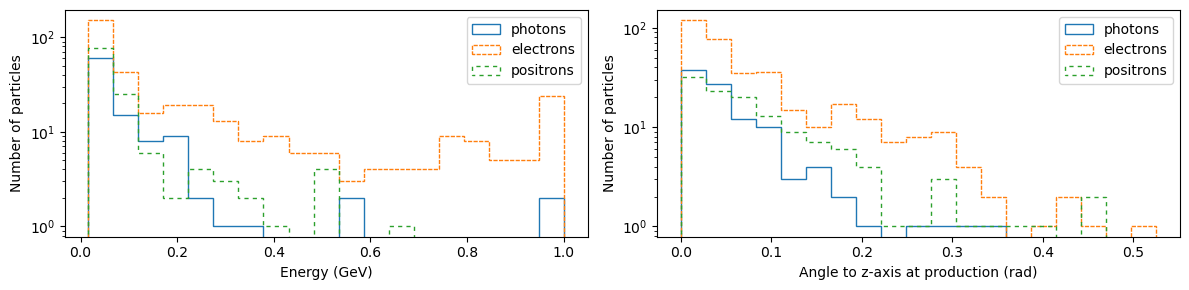

In [108]:
plot_shower(test_shower)
plot_shower(original_shower)

In [87]:
from PETITE.physical_constants import GeVsqcm2
from PETITE.targets import Target

In [94]:
Target(target).get_n_target_for_process('Brem')

1.1010657223742076e+23

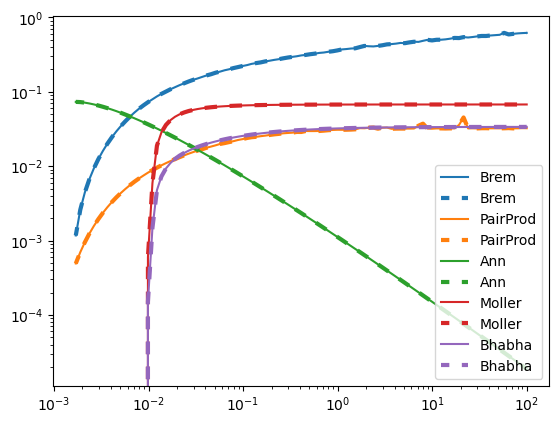

In [102]:

target = 'graphite'

def plot_xsecs(label):
    E = np.geomspace(0.0017, 100, 101)

    cross_section_file = open('../coarsegrid_test/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = interp1d(*np.array(cross_section_dict[label][target]).T)

    n = Target(target).get_n_target_for_process(label)
    c = plt.loglog(E, n*GeVsqcm2*xsec1(E), label=label)
        
    cross_section_file = open('../coarsegrid_test/' + "sm_xsec_interp.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = cross_section_dict[label][target](E)
    plt.loglog(E, xsec1, label=label, color = c[0].get_color(), ls=(1, (3,)), lw=3)

plot_xsecs('Brem')
plot_xsecs('PairProd')
plot_xsecs('Ann')
plot_xsecs('Moller')
plot_xsecs('Bhabha')

plt.legend()

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_3705/766842776.py:13: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(E, 1/(xsec1(E)/xsec0(E)), label=label)


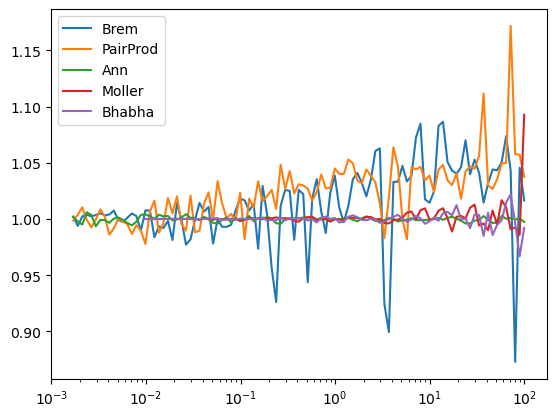

In [74]:
target = 'graphite'

def plot_comparison(label):
    cross_section_file = open('../data/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec0 = interp1d(*np.array(cross_section_dict[label][target]).T)

    cross_section_file = open('../coarsegrid_test/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = interp1d(*np.array(cross_section_dict[label][target]).T)

    E = np.geomspace(0.0017, 100, 101)
    plt.semilogx(E, 1/(xsec1(E)/xsec0(E)), label=label)

plot_comparison('Brem')
plot_comparison('PairProd')
plot_comparison('Ann')
plot_comparison('Moller')
plot_comparison('Bhabha')

plt.legend()

## Comparison new generation with original data

In [42]:
sLead = Shower(PETITE_home_dir+'data/', "lead", 0.01, fast_MCS_mode=True, load_xsec_interp=False)

In [43]:
sLead.get_dict_dir()

'/Users/mhostert/Repos/PETITE/data/'

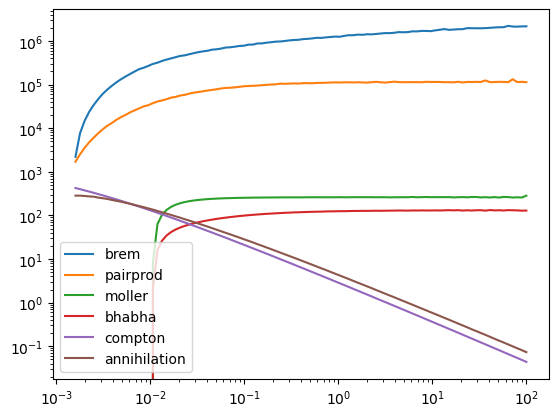

In [45]:
def make_xsecplot(s, LS='-'):
    E, xsec = np.array(s.get_brem_cross_section()).T
    plt.plot(E, xsec, label='brem', ls=LS)
    E, xsec = np.array(s.get_pairprod_cross_section()).T
    plt.plot(E, xsec, label='pairprod', ls=LS)
    E, xsec = np.array(s.get_moller_cross_section()).T
    plt.plot(E, xsec, label='moller', ls=LS)
    E, xsec = np.array(s.get_bhabha_cross_section()).T
    plt.plot(E, xsec, label='bhabha', ls=LS)
    E, xsec = np.array(s.get_compton_cross_section()).T
    plt.plot(E, xsec, label='compton', ls=LS)
    E, xsec = np.array(s.get_annihilation_cross_section()).T
    plt.plot(E, xsec, label='annihilation', ls=LS)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

make_xsecplot(sLead)
# make_xsecplot(oLead, LS='--')

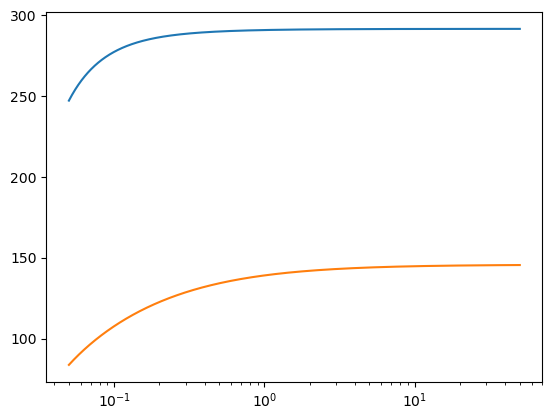

In [17]:
erange=np.geomspace(0.05, 50, 1000)
sigma_moller=[]
sigma_bhabha=[]
for e in erange:
    event_info ={'E_inc': e, 'Ee_min': 0.005, 'Eg_min': 0.001}
    sigma_moller.append(proc.sigma_moller(event_info=event_info))
    sigma_bhabha.append(proc.sigma_bhabha(event_info=event_info))
plt.plot(erange, sigma_moller, label='Moller')
plt.plot(erange, sigma_bhabha, label='Moller')
plt.xscale('log')

In [28]:
test_shower[0].vars()

AttributeError: 'Particle' object has no attribute 'vars'

## Original

Total number of particles:  974
Number of (photons, electrons, positrons):  0 974 0


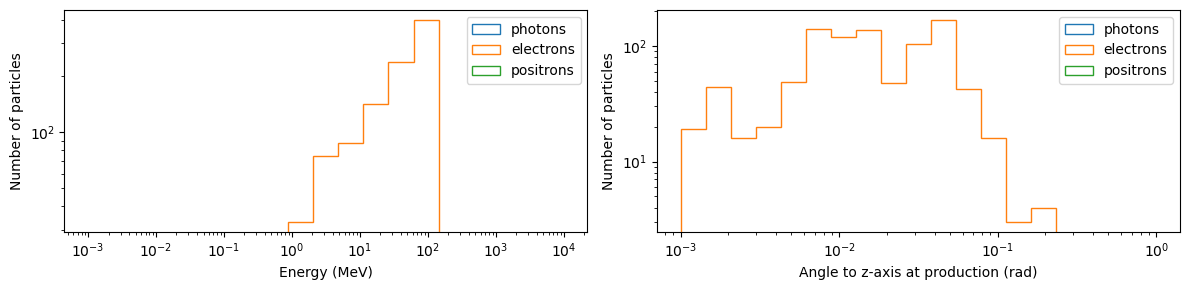

In [44]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_lead))

photons = [p for p in standard_shower_lead if p.get_pid() == 22]
electrons = [p for p in standard_shower_lead if p.get_pid() == 11]
positrons = [p for p in standard_shower_lead if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))

# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

#### Generate a DarkShower object with a dark vector mass of 30 MeV, tracking particle energies down to 30 MeV

The `DarkShower` class inherits from the `Shower` class. This means that instances of `DarkShower` can use the `generate_shower` method to produce a SM cascade if needed. `DarkShower` includes additional data and routines that enable the simulation of BSM particle production with a specific mass from a pre-calculated SM shower.

More options, for instance including only certain production modes of the BSM particle, are available as optional arguments when initializing the object.

In [5]:
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.030, 0.0323)

Weights not previously calculated, calculating now...


/Users/mhostert/Repos/PETITE/src/PETITE/shower.py:290: RuntimeWarning: divide by zero encountered in scalar power
  return cmtom*(self._NSigmaBrem(Energy) + self._NSigmaAnn(Energy) + self._NSigmaBhabha(Energy))**-1


dRate not previously calculated, calculating now...


The pre-saved VEGAS integrator objects have specific vector masses for training. By default, PETITE selects the nearest mass allowed below the provided one for simulation

In [6]:
print(sGraphite._mV_list)
print(sGraphite._mV)
print(sGraphite._mV_estimator)

[0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
0.03
0.03


Samples are drawn for BSM production in the same approach as SM production in PETITE, using VEGAS-trained integrators at nearby energies for different physics process. Here is an example of simulating dark electron/positron bremsstrahlung of this 30 MeV particle.

In [8]:
Ebeam = 1.
ntrials = []
xs = []
for k in tqdm(range(30000)):
    # draw_dark_sample samples the "raw" kinematic variables that can be translated into particle momenta
    s0 = sGraphite.draw_dark_sample(Ebeam, process="DarkBrem", VB=True)
    xs.append([s0[0], s0[1]])
    # This saves the number of importance samples drawn before one was accepted - this can be used to diagnose the efficiency of sampling using nearby energies
    ntrials.append(s0[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:54<00:00, 554.96it/s]


Plot the drawn distribution of $x_0$ (the proxy for the outgoing vector energy)

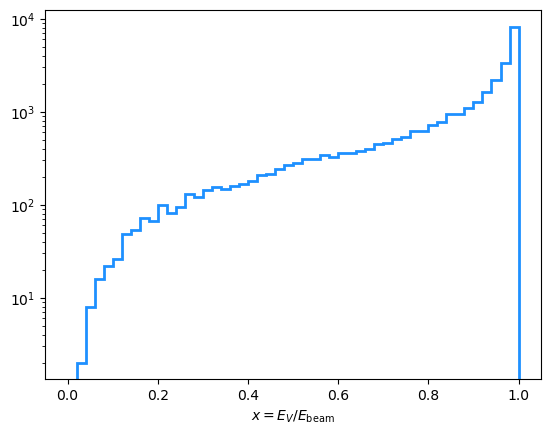

In [10]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 51), histtype='step', lw=2, color='dodgerblue')
plt.xlabel(r'$x = E_V/E_{\mathrm{beam}}$')
plt.gca().set_yscale('log')

### Dark Shower Production

We now wish to simulate an ensemble of SM showers, each generated by a single 10 GeV photon hitting this graphite target. For each photon-on-target, the SM side of PETITE will generate a SM shower of particles, tracking down to our desired 30 MeV particle energy.

Then, PETITE uses `DarkShower` to take that list of SM particles and determine, for each one, the probability of emitting a 30 MeV vector boson $V$ through a number of different BSM processes (each one labelled by a different "generation_process" in the `Particle`'s `get_ids()` call). We will then inspect the resulting weighted distribution of these particles.

In [11]:
# Set up lists to organize data according to BSM process and parent particle
Energies, Weights, particles = {}, {}, {}
parent_pid_options = [11, -11, 22]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    particles[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []
        particles[pr][pid] = []

In [12]:
n_photons_on_target = 30
for kk in tqdm(range(n_photons_on_target)):
    p0 = [10, 0, 0, 10]
    r0 = [0, 0, 0]
    pdict = {"PID":22, "weight":1.0/n_photons_on_target}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM));
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])
        particles[genprocess][parent_pid].append(p0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:20<00:00,  2.68s/it]


(0.01, 10.0, 1e-06, 10.0)

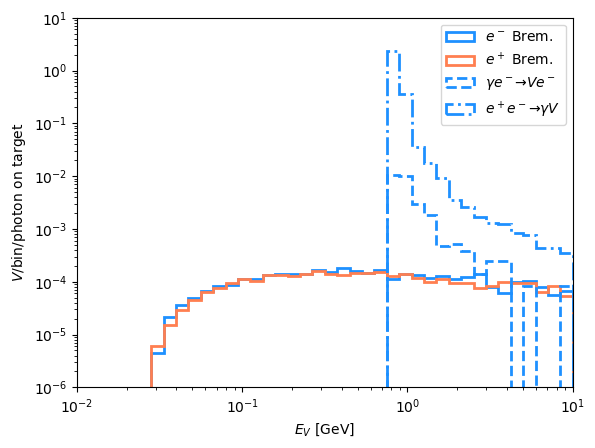

In [13]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{photon\ on\ target}$")
plt.gca().axis([0.01, 10, 1e-6, 10])

This figure shows a histogram of all $V$ produced as a part of this process, but does not take into account the directional information of these particles. For instance, some distributions here may have a significantly larger off-axis component than others, yielding a different (relative) size of these histograms at a small solid-angle on-axis detector.

Let's imagine we have a detector situated 300 meters downstream of this photon beam, with a radius of 2.0 meters. We can now use the predefined "detector_cut()" function (in shower.py) to select out the BSM particles pointing towards the front face of this detector only.

(0.01, 10.0, 1e-06, 10.0)

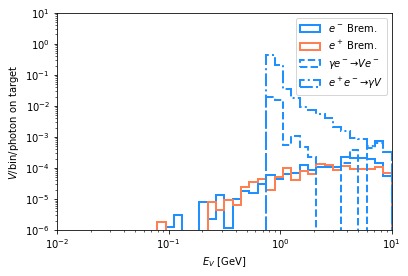

In [25]:
detector_distance = 300 # meters
detector_radius = 2.0 # meters

cut_particles_DarkBrem_electrons = detector_cut(particles['DarkBrem'][11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_electrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_electrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")

cut_particles_DarkBrem_positrons = detector_cut(particles['DarkBrem'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_positrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_positrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")

cut_particles_DarkComp = detector_cut(particles['DarkComp'][22], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkComp])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkComp])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")

cut_particles_DarkAnn = detector_cut(particles['DarkAnn'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkAnn])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkAnn])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")

plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{photon\ on\ target}$")
plt.gca().axis([0.01, 10, 1e-6, 10])